In [1]:
import pandas as pd
from pandas.io.json import loads, json_normalize

# challenge specifies to load fullVisitorId as a string to guarantee uniqueness
id_to_str = {'fullVisitorId': str}

#train = pd.read_csv('./all/train.csv', dtype=id_to_str)
#test  = pd.read_csv('./all/test.csv', dtype=id_to_str)

In [2]:
def parse_json_cols(df):
    for col in ['device', 'geoNetwork', 'totals', 'trafficSource']:
        # load the json and separate
        df_json = json_normalize(df[col].apply(loads), sep='/')
        df_json.columns = [(col + '/' + c) for c in df_json.columns]
        df.drop(columns=col, inplace=True)
        df = pd.concat([df, df_json], axis=1)
    return df

#
train = parse_json_cols(train)
test  = parse_json_cols(test)

---
# Examine data

### Dates are not parsed and visitStartTime is in POSIX time
    * visitStartTime makes Date redundant (more information encoded)
    * need to get continuous time data (hour, minute)

In [3]:
from datetime import datetime

def parse_dates(df):
    df['visitStartTime'] = df['visitStartTime'].apply(lambda time: datetime.fromtimestamp(time))
    df['year']  = df['visitStartTime'].dt.year
    df['month'] = df['visitStartTime'].dt.month
    df['day']   = df['visitStartTime'].dt.day
    df['hour']  = df['visitStartTime'].dt.hour + (df['visitStartTime'].dt.minute/60)
    df.drop(columns=['date', 'visitStartTime'], inplace=True)

    return df

#
train = parse_dates(train)
test  = parse_dates(test)

### Several columns have NaN values
* Every value in totals should have a lower bound of 0.
* Will fill remainder with most frequent value

In [4]:
nan_series = train.isna().any()
nan_true   = nan_series[nan_series == True]
nan_true

totals/bounces                                  True
totals/newVisits                                True
totals/pageviews                                True
totals/transactionRevenue                       True
trafficSource/adContent                         True
trafficSource/adwordsClickInfo/adNetworkType    True
trafficSource/adwordsClickInfo/gclId            True
trafficSource/adwordsClickInfo/isVideoAd        True
trafficSource/adwordsClickInfo/page             True
trafficSource/adwordsClickInfo/slot             True
trafficSource/campaignCode                      True
trafficSource/isTrueDirect                      True
trafficSource/keyword                           True
trafficSource/referralPath                      True
dtype: bool

In [5]:
def clean_nans(df):
    totals_cols = list(filter(lambda c : c.startswith('totals'), df.columns))
    for i in totals_cols:
        df[i] = df[i].astype(float)
        df[i].fillna(0, inplace=True)
   
    nan_series = df.isna().any()
    nan_true   = nan_series[nan_series == True]
    remaining_nan_cols = list(set(nan_true.index) - set(totals_cols))
    
    for i in remaining_nan_cols:
        # fill with most frequent value
        df[i].fillna(df[i].value_counts().index[0], inplace=True)
        
    return df

#
train = clean_nans(train)
test  = clean_nans(test)

### Several columns have 1 unique value
    * Provide no information, so will drop

In [6]:
for col in train:
    if len(train[col].unique()) == 1:
        print(col)

socialEngagementType
device/browserSize
device/browserVersion
device/flashVersion
device/language
device/mobileDeviceBranding
device/mobileDeviceInfo
device/mobileDeviceMarketingName
device/mobileDeviceModel
device/mobileInputSelector
device/operatingSystemVersion
device/screenColors
device/screenResolution
geoNetwork/cityId
geoNetwork/latitude
geoNetwork/longitude
geoNetwork/networkLocation
totals/visits
trafficSource/adwordsClickInfo/criteriaParameters
trafficSource/adwordsClickInfo/isVideoAd
trafficSource/campaignCode
trafficSource/isTrueDirect


In [7]:
def drop_single_val_cols(df):
    for col in df:
        if len(df[col].unique()) == 1:
            df.drop(columns=[col], inplace=True)
    return df

#
train = drop_single_val_cols(train)
test  = drop_single_val_cols(test)

### A lot of data is categorical
* Thinks like referal links, locations, and keywords are categorical and need to be represented as such
* Will use sklearn's LabelEncoder
    * fit on all possible values for a column, then transform

In [8]:
list(train.select_dtypes(include='object').columns)

['channelGrouping',
 'fullVisitorId',
 'sessionId',
 'device/browser',
 'device/deviceCategory',
 'device/operatingSystem',
 'geoNetwork/city',
 'geoNetwork/continent',
 'geoNetwork/country',
 'geoNetwork/metro',
 'geoNetwork/networkDomain',
 'geoNetwork/region',
 'geoNetwork/subContinent',
 'trafficSource/adContent',
 'trafficSource/adwordsClickInfo/adNetworkType',
 'trafficSource/adwordsClickInfo/gclId',
 'trafficSource/adwordsClickInfo/page',
 'trafficSource/adwordsClickInfo/slot',
 'trafficSource/campaign',
 'trafficSource/keyword',
 'trafficSource/medium',
 'trafficSource/referralPath',
 'trafficSource/source']

In [9]:
from sklearn.preprocessing import LabelEncoder

for i in train.select_dtypes(include='object').columns:
    if i == 'fullVisitorId':
        continue

    # get list of all possible categories for each column
    all_categories = list(set(list(train[i].unique()))\
                     | set(list(test[i].unique())))

    encoder = LabelEncoder()
    # fit on column
    encoder.fit(all_categories)
    train[i] = encoder.transform(train[i])
    test[i]  = encoder.transform(test[i])

### Predict natural log of revenue
* Target specified as ln(total transaction revenue + 1)
    * Need to convert transactionRevenue column to accomodate
* Evaluate with RMSE

In [10]:
from numpy import log1p

# to make the line more readable
i = 'totals/transactionRevenue'

train[i] = train[i].apply(lambda revenue: log1p(revenue))

# External Dataset: OECD Consumer Confidence Index

OECD - Total from Jan 2016 - Sep 2018

https://data.oecd.org/leadind/consumer-confidence-index-cci.htm#indicator-chart


* OECD (2018), Consumer confidence index (CCI) (indicator). doi: 10.1787/46434d78-en (Accessed on 11 October 2018)

In [11]:
def add_cci(df):
    cci = pd.read_csv('./all/oecd_total_cci.csv', index_col=0)
    cci_dict = cci.to_dict()['Value']
    df['year-month']  = df['year'].astype(str) + '-' + df['month'].astype(str)
    
    df['cci'] = df['year-month'].map(cci_dict)
    df['cci'].fillna(df['cci'].median(), inplace=True)
    
    df.drop(columns=['year-month'], inplace=True)
    return df

train = add_cci(train)
test  = add_cci(test)

#### Save Preprocessed DataFrames

In [12]:
#train.to_csv('./all/p_train.csv')
#test.to_csv('./all/p_test.csv')

#### Load Preprocessed DataFrames

In [14]:
train = pd.read_csv('./all/p_train.csv', dtype=id_to_str)
test  = pd.read_csv('./all/p_test.csv', dtype=id_to_str)

---
# Visualize

In [15]:
corr_matrix = train.corr()

In [16]:
corr_matrix['totals/transactionRevenue'].sort_values(ascending=False)

totals/transactionRevenue                       1.000000
totals/pageviews                                0.400732
totals/hits                                     0.378804
geoNetwork/country                              0.080750
hour                                            0.040587
visitNumber                                     0.023666
cci                                             0.016590
geoNetwork/metro                                0.015912
visitId                                         0.010491
year                                            0.007604
trafficSource/adContent                         0.003246
trafficSource/medium                            0.001241
trafficSource/adwordsClickInfo/slot             0.000612
sessionId                                      -0.000027
Unnamed: 0                                     -0.000241
trafficSource/adwordsClickInfo/adNetworkType   -0.000315
channelGrouping                                -0.000807
day                            

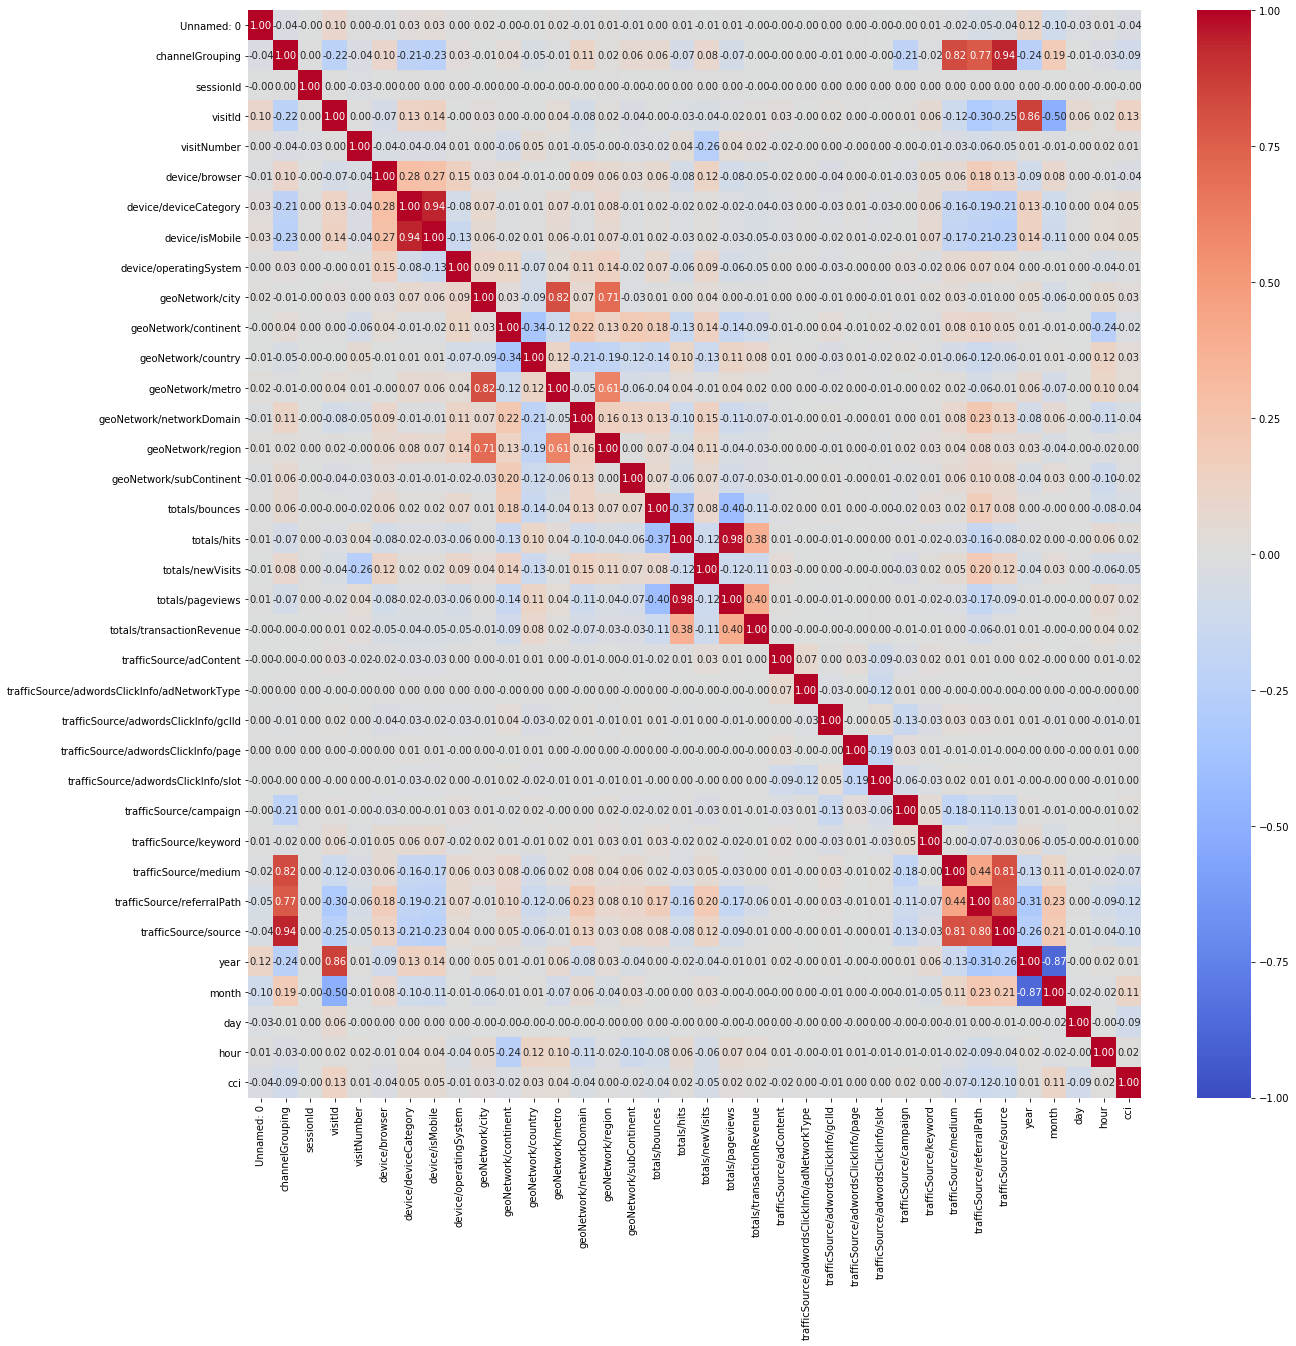

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, vmin=-1, vmax=1, 
            cbar_kws=dict(ticks=list(np.arange(-1.0, 1.1, 0.25))), fmt='.2f')
plt.show()

---
# Train models

In [35]:
def get_tt_split(df):
    X = df.drop(columns=['totals/transactionRevenue', 'fullVisitorId'])
    y = df['totals/transactionRevenue']
    
    return train_test_split(X, y, test_size = 0.1, random_state = 3)

### Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from numpy import clip

def train_lr(df):
    X_train, X_test, y_train, y_test = get_tt_split(df)
    
    model = LinearRegression()
    print('Training model: {0}...\n'.format('lr'))
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    test_predictions = clip(test_predictions, a_min=0, a_max=None)
    
    mse = mean_squared_error(y_test, test_predictions)
    rmse = sqrt(mse)
    
    print('=====')
    print('RMSE:', rmse)
    print('=====\n\n==========')
    print('INTERCEPT:', model.intercept_)
    print('==========\n\n==========================')
    print('COEFFICIENTS (decreasing):')
    print('==========================')
    coefficients = list(zip(X_test.columns, model.coef_))
    coefficients.sort(key = lambda c: c[1])
    for i in coefficients[::-1]:
        print('{0}:\n\t{1}\n'.format(i[0], i[1]))
    
    
    return model

In [37]:
lr_model = train_lr(train)

Training model: lr...

=====
RMSE: 1.813052789301633
=====

INTERCEPT: -8442.974413393793

COEFFICIENTS (decreasing):
year:
	4.272181216227391

month:
	0.3595432453541382

totals/bounces:
	0.3398822802511242

totals/pageviews:
	0.2625137467380266

cci:
	0.17682185412456342

trafficSource/adwordsClickInfo/slot:
	0.0947172547653754

channelGrouping:
	0.0723506757489342

day:
	0.011638688505081886

hour:
	0.0026497657616815083

trafficSource/adContent:
	0.0018305936123256701

trafficSource/source:
	0.0011679666662089251

geoNetwork/subContinent:
	0.0009573249568398184

geoNetwork/country:
	0.000724172194564088

device/browser:
	0.0005353187190290321

geoNetwork/region:
	0.0001904811348726373

trafficSource/adwordsClickInfo/gclId:
	5.71381178492804e-06

trafficSource/keyword:
	1.78999948580523e-06

sessionId:
	-1.3454940075039959e-09

Unnamed: 0:
	-3.105486113030498e-08

visitId:
	-1.3002066871965543e-07

geoNetwork/metro:
	-6.514773850997266e-07

geoNetwork/networkDomain:
	-7.528175799747

In [38]:
import xgboost as xgb
from xgboost import DMatrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from numpy import clip

def train_xgb(df):
    X_train, X_test, y_train, y_test = get_tt_split(df)
    
    print('Training model: {0}...'.format('xgb'))
    model = xgb.train({'eta':0.6}, DMatrix(X_train, y_train))
    test_predictions = model.predict(DMatrix(X_test))
    test_predictions = clip(test_predictions, a_min=0, a_max=None)
    
    mse = mean_squared_error(y_test, test_predictions)
    rmse = sqrt(mse)
    
    print('=====')
    print('RMSE:', rmse)
    return model

In [39]:
xgb_model = train_xgb(train)

Training model: xgb...
=====
RMSE: 1.6448747325239255


---
# Specify model

In [23]:
selected_model = 'xgb'

# Create Submission

In [34]:
X_test = test.drop(columns=['fullVisitorId'])

if selected_model == 'lr':
    model = train_lr(train)
elif selected_model == 'xgb':
    model = train_xgb(train)
    X_test = DMatrix(X_test)

real_predictions = model.predict(X_test)
real_predictions = clip(real_predictions, a_min=0, a_max=None)

real_df = test['fullVisitorId'].to_frame()
real_df['PredictedLogRevenue'] = real_predictions
real_df['fullVisitorId'] = real_df['fullVisitorId'].astype('str')
real_df = real_df.groupby('fullVisitorId').sum()
real_df.to_csv('submission.csv')

Training model: xgb...
=====
RMSE: 1.3485427859169676
